In [1]:
suppressMessages( library(dplyr) ) # Manipulações de funções
suppressMessages( library(mvtnorm) ) # Manipulações de funções
suppressMessages( library(tidyr) ) # Manipulações de funções

# Regression trees
suppressMessages( library(rpart) )

# Pacotes para a construção de gráficos
suppressMessages( library(ggplot2) )
suppressMessages( library(cowplot) )
suppressMessages( library(latex2exp) )
suppressMessages( library(GGally) )

# Configurações padrão para os gráficos do ggplot2 no notebook
t = theme(plot.title = element_text(size=26, hjust=0.5),
          axis.title = element_text(size=20),
          axis.text = element_text(size=16),
          legend.title = element_text(size = 20),
          legend.text = element_text(size = 16),
          plot.subtitle = element_text(size = 18, face="bold"))
theme_set(theme_minimal()+t)

# Simulate Longitudinal Data

First, let's start generating a simple linear mixed effects dataset. Of course the best way of modeling this dataset would be to straighforward apply the mixed effects model structure. Although, for our try in implementing the MERT algorithm from scratch it may be useful to start with a simpler step.

For the data generation proccess, let's consider that time $t_{ij}$ is observed for each individual $i$ at its $j$th observation. We will create a general function that receives a general matrix $X_i$ for the fixed effects and $Z_i$ for the random effects. The distribution of the random effects will be fixed as Normal. We state the model as
\begin{equation*}
    Y_{i} = X_i \beta + Z_i b_i + \varepsilon_{i},
\end{equation*}
where $Y_{i}$ is the vector with all the $n_i$ observations of the $i$th individual studied. $X_i$ is the matrix of covariates associated to the fixed effects vector, $\beta$, $Z_i$ is the matrix of covariates associated to the random effects vector (individual-wise), $b_i$ and $\varepsilon_{i}$ represents a $n_i$ sized vector o random within individual residuals. In this case we strictly suppose that $Z_i$ is composed only by a subset of columns from $X_i$. At first, let's consider that $b_i \sim N(0, D)$ and $\varepsilon \sim N_{n_i}(0, \sigma^2 I_{n_i})$. Given that all subjects are independent of each other, the simulation proccess can be simply separated for each individual.

In [2]:
generate_subject <- function(Xi, beta, Zi, D, sigma2, random_state = NULL){
    # Only if requested a non NULL seed
    if(!is.null(random_state)){
        # Save the current global random state so that the randomness inside the function doesn't affect the overall randomness
        old_random_state <- get0(".Random.seed", envir = .GlobalEnv, inherits = FALSE)
        set.seed(random_state)
    }
    
    ni <- nrow(Xi) # Number of observations from the subject
    p <- ncol(Xi) # Numer of fixed effects
    q <- ncol(Zi) # Numer of random effects
    
    # Generate the random effects vector for this subject
    # If q is NULL or q = 1, we have only one column in Zi
    if(is.null(q) || q == 1 ){
        bi <- rnorm(1, mean = 0, sd = sqrt(D))
        Zi <- as.matrix(Zi)
    }else{
        bi <- rmvnorm(1, mean = rep(0, q), sigma = D ) %>% t
    }
    
    # Generate the residuals epsilon
    e <- rmvnorm(1, mean = rep(0, ni), sigma = sigma2 * diag(ni) ) %>% t
    
    if(!is.null(random_state)){
        # Returns the overall random state to the one from before the function call
        assign(".Random.seed", old_random_state, envir = .GlobalEnv, inherits = FALSE)
    }
    
    Yi <- Xi %*% beta + Zi %*% bi + e
    
    return(list(
        "Y" = as.vector(Yi),
        "random_effects" = as.vector(bi),
        "residuals" = as.vector(e)
    ))
}

In [3]:
set.seed(10)

# Intercept + discrete time (ni = 6)
Xi <- matrix(c(
    1, 0,
    1, 1,
    1, 2,
    1, 3,
    1, 4,
    1, 5
), ncol = 2)
# Global intercept of 4 and slope of -1
beta <- c(4, -1)

# Random intercept and random slopes
Zi <- Xi
# The random intercept is independent of the random slope
D <- diag(c(1, 2))
sigma2 <- 1

subject <- generate_subject(Xi, beta, Zi, D, sigma2)

cat("Response:")
subject$Y
cat("Residuals:")
subject$residuals
cat("Random effects:")
subject$random_effects

Response:

[1]  1.3868432 -4.3808850  3.0527189 -0.6337493  1.5500976  1.3709541

Residuals:

[1] -1.3713305 -0.5991677  0.2945451  0.3897943 -1.2080762 -0.3636760

Random effects:

[1]  0.01874617 -0.26057244

In [4]:
# Generate multiple subjects from the usual mixed effects model
generate_sample <- function(N, Xi, beta, Zi, D, sigma2){
    # If it's given only one matrix Xi, consider all the subjects to have the same Xi
    if( all(class(Xi) != "list") ){ Xis <- rep(list(Xi), N) }else{ Xis <- Xi }
    # If it's given only one matrix Zi, consider all the subjects to have the same Zi
    if( all(class(Zi) != "list") ){ Zis <- rep(list(Zi), N) }else{ Zis <- Zi }
    
    subjects <- sapply(1:N, function(i){
        Xi <- Xis[[i]]
        Zi <- Zis[[i]]
        
        subject <- generate_subject(Xi, beta, Zi, D, sigma2)
        subject
    }) %>% t %>% as.data.frame
    
    # Matrix with all the random effects from each subject
    random_effects <- Reduce(rbind, subjects$random_effects)
    # Matrix with all the residuals from every subject
    residuals <- Reduce(rbind, subjects$residuals)
    
    rownames(random_effects) <- rep("", nrow(random_effects))
    rownames(residuals) <- rep("", nrow(residuals))
    
    # Column names of all the variables
    col_names <- colnames(Xis[[1]])
    # In order to build complete dataset, first removes the intercepts columns from all the matrices
    Xis <- lapply(Xis, function(Xi){
        if( all(Xi[,1] == 1) ){ Xi <- Xi[,-1] }
        # If objects turns out to be of class numeric (single column), convert it to vector matrix
        if( all(class(Xi) == "numeric") ){
            Xi <- as.matrix(Xi)
            colnames(Xi) <- col_names[2]
        }
        Xi
    })
    
    # data.frame with subjects' responses as list type column
    Y <- tibble(response = subjects$Y )
    
    # Each remaining column of the Xi and Zi matrices are then transformed to grouped variables in a data.frame
    covariates <- sapply(Xis, function(Xi){
        # Each columns of the design matrix is a column of the dataset
        new_columns <- list()
        for(i in 1:ncol(Xi)){
            new_columns[[i]] <- Xi[,i]
        }
        
        # Adds a column of zeros just to guarantee that sapply is returning a matrix and not a vector
        c(new_columns, 0)
    }) %>% t %>% as.data.frame
    
    # Final generated dataset
    data <- cbind(
        1:nrow(Y),
        Y,
        covariates
    )
    
    # Removes the zero column added previously
    data <- data[,-ncol(data)]
    colnames(data) <- c("id", "Y", colnames(Xis[[1]]))
    
    # Unnest all columns
    data <- data %>% unnest(cols = colnames(data)[-1])
    
    return(list(
        "Xis" = Xis,
        "Zis" = Zis,
        "covariates" = covariates,
        "data" = data,
        "Y" = Y,
        "bi" = random_effects,
        "epsiloni" = residuals
    ))
}

### Example: Random intercepts model

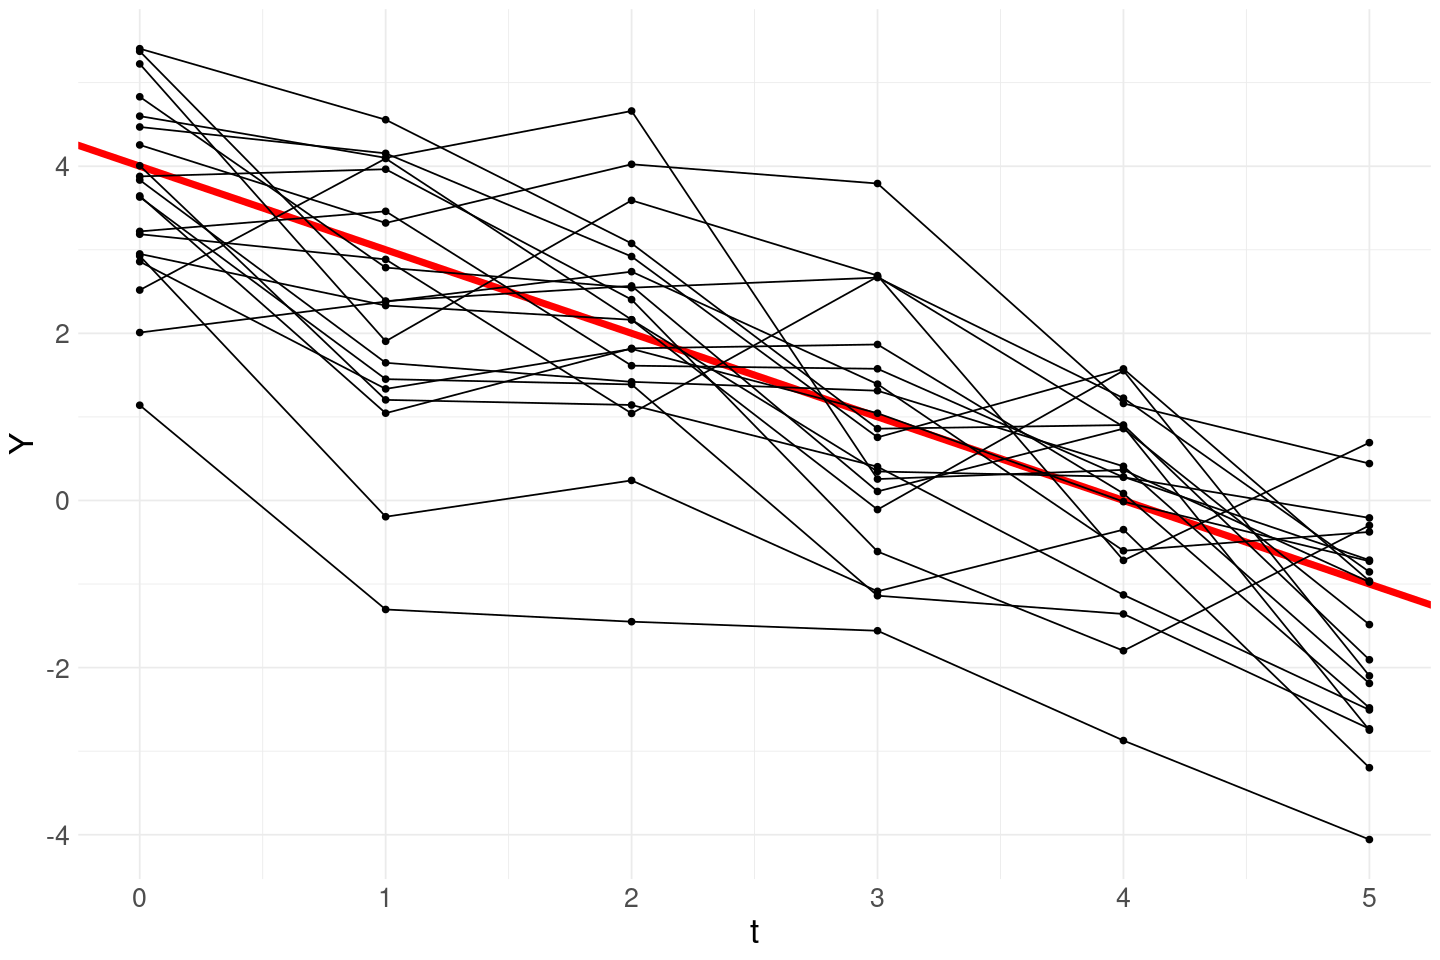

In [5]:
set.seed(10)

# Intercept + discrete time (ni = 6)
Xi <- matrix(c(
    1, 0,
    1, 1,
    1, 2,
    1, 3,
    1, 4,
    1, 5
), ncol = 2, byrow = TRUE)
# The column names have to be specified before calling the generate_sample function!
colnames(Xi) <- c("Intercept", "t")

# Global intercept of 4 and slope of -1
beta <- c(4, -1)

# Random intercept and random slopes
Zi <- as.matrix(Xi[,1])

D <- 1

N <- 20
generated_data <- generate_sample(N, Xi, beta, Zi, D, sigma2)
df <- generated_data$data

options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(df)+
    geom_abline(intercept = beta[1], slope = beta[2], linewidth = 2, color = "red")+
    geom_line(aes(x = t, y = Y, group = id))+
    geom_point(aes(x = t, y = Y, group = id))

### Example: Random intercepts and slopes model

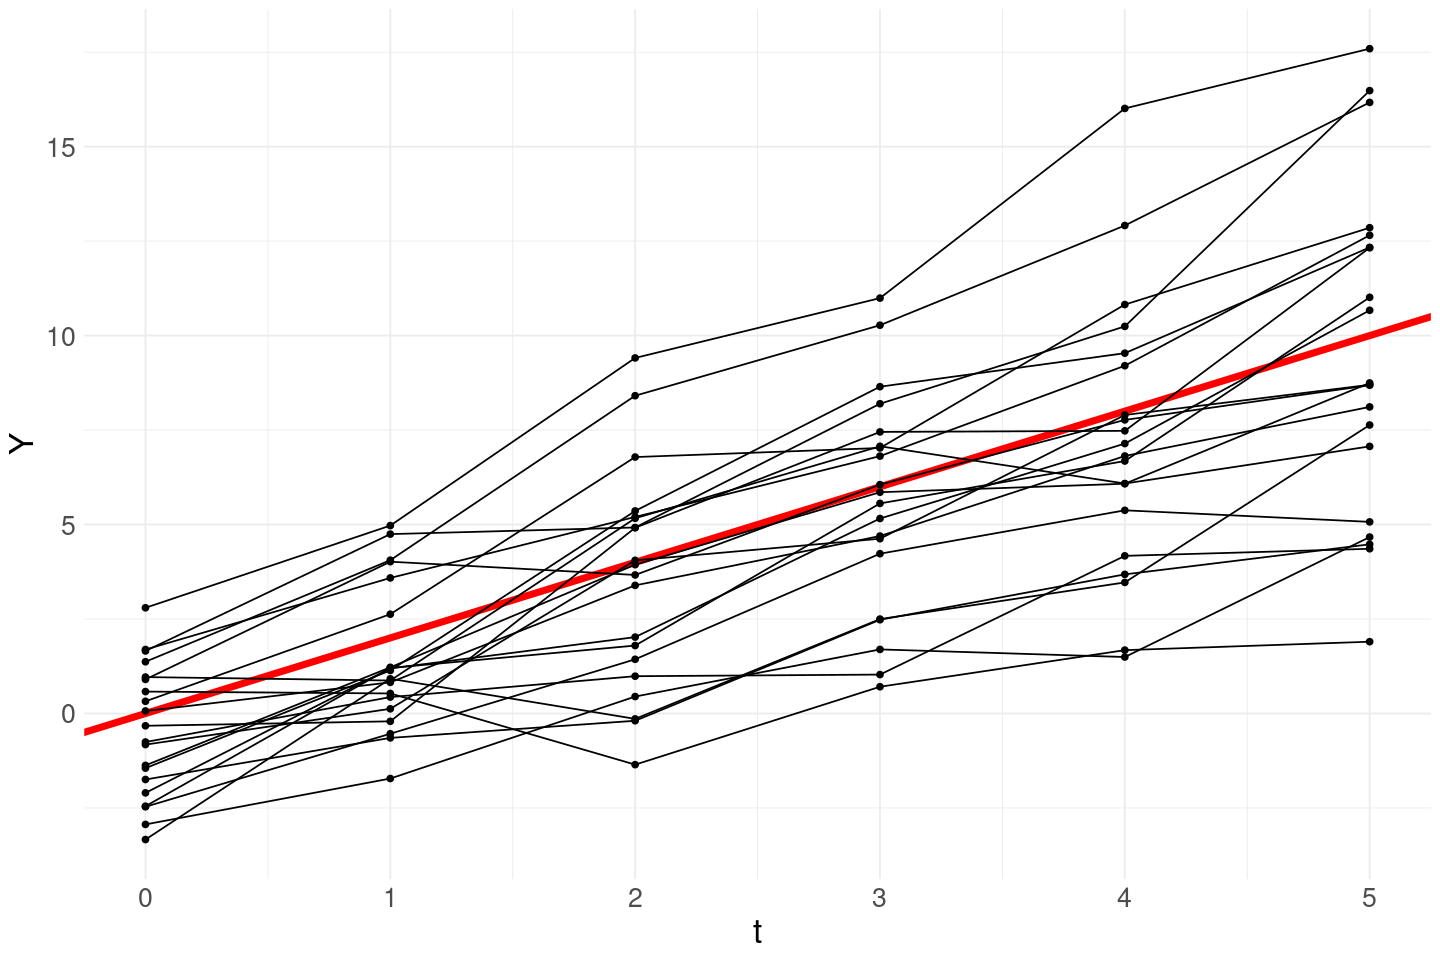

In [6]:
set.seed(10)

# Intercept + discrete time (ni = 6)
Xi <- matrix(c(
    1, 0,
    1, 1,
    1, 2,
    1, 3,
    1, 4,
    1, 5
), ncol = 2, byrow = TRUE)

colnames(Xi) <- c("Intercept", "t")

# Global intercept of 4 and slope of -1
beta <- c(0, 2)

# Random intercept and random slopes
Zi <- Xi

D <- matrix(c(3,0.5,
              0.5,1), nrow = 2, byrow = TRUE)
sigma2 <- 1

N <- 20
generated_data <- generate_sample(N, Xi, beta, Zi, D, sigma2)
df <- generated_data$data

options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(df)+
    geom_abline(intercept = beta[1], slope = beta[2], linewidth = 2, color = "red")+
    geom_line(aes(x = t, y = Y, group = id))+
    geom_point(aes(x = t, y = Y, group = id))

# The MERT algorith structure

Now that we finally finished implementing a code to generate some fake data, let's code the actual algorithm proposed by Hajjem, given by
\begin{align*}
    Y &= f\left(X_i\right) + Z_i b_i + \varepsilon_i,\\
    b_i &\sim N(0, D), \varepsilon_i \sim N(0, \sigma^2 I_{n_i}),\\
    i &= 1, \dots, n.
\end{align*}
In the original paper it was presented the base structure for $f$ being a regression tree method, but the entire setup can be easily generalized to support any function f called during the training of the method.

Let's start with the simplest of the mixed effects model, that is the random intercepts model with fixed components. For this we shall recover the design matrices from the actual data.

In [7]:
# Fixed intercept + slope
Xi <- matrix(c(
    1, 0, 1, 1, 1, 2, 1, 3, 1, 4, 1, 5
), ncol = 2, byrow = TRUE)
colnames(Xi) <- c("Intercept", "t")
beta <- c(1, 2)

# Random intercept model
Zi <- Xi[,1]

D <- 2
sigma2 <- 1

N <- 50
generate_data <- generate_sample(N, Xi, beta, Zi, D, sigma2)
df <- generate_data$data

# Group the dataset by subject index
df_grouped <- df %>% group_by(id) %>% summarise(
    Y = list(Y),
    t = list(t)
)
head(df_grouped, 4)

id,Y,t
<int>,<list>,<list>
1,"1.374308, 4.444771, 5.224313, 7.484807, 9.246397, 12.882858","0, 1, 2, 3, 4, 5"
2,"-0.8925467, -0.5114578, 1.7862895, 4.5090440, 7.0676237, 9.9857137","0, 1, 2, 3, 4, 5"
3,"1.469957, 2.421065, 3.883962, 7.152605, 8.741598, 10.618289","0, 1, 2, 3, 4, 5"
4,"0.5497403, 3.7115404, 6.5293492, 9.9782561, 9.6047617, 12.1912921","0, 1, 2, 3, 4, 5"


From now on let's suppose we only have knowledge about the dataset. We shall recover all the necessary information in order to fit the MERT model.

In [8]:
train_MERT <- function(df, fixed_effects_form, Ys, Xis, Zis, e, verbose = TRUE, max_iter = 200){    
    N <- length(Xis)
    count <- 0
    q <- ncol(Zis[[1]])
    
    # ------------------ Step 0 ------------------
    r <- 0
    bi_hat <- rep(list(matrix(rep(0, q))), N)
    sigma2_hat <- 1
    D_hat <- diag(q)
    
    # Stop criterion
    GLLs <- c(0)
    
    converged <- FALSE
    while(!converged){
        
        r <- r + 1
        
        # ------------------ Step 1 ------------------
        
        # Recover the vectors Yi* for all subjects and join them in a single big vector
        
        # ------------------ (i)
        Y_star <- lapply(1:N, function(i){
            Yi <- Ys[[i]]
            Zi <- Zis[[i]]
            bi <- bi_hat[[i]]
            
            Yi - Zi %*% bi
        })
        Y_star <- Reduce(rbind, Y_star)
        
        df_star <- df
        df_star$Y <- Y_star[,1]
        
        # ------------------ (ii)
        # Fit and obtain the f_hat values for all individuals
        fit_rpart <- rpart(fixed_effects_form, data = df_star)
        f_y_hat <- predict(fit_rpart)
        
        # return(f_y_hat)
        
        # Once predicted by the rpart, segment the responses by subject again
        df_star <- cbind(df_star, f_y_hat)
        
        f_y_hat <- (df_star %>% group_by(id) %>% summarise(f_y_hat = list(f_y_hat)))$f_y_hat
        
        # ------------------ (iii)
        Vi_hat <- list()
        Vi_hat_inv <- list()
        for(i in 1:N){
            Yi <- Ys[[i]]
            f_hat <- f_y_hat[[i]]
            
            Zi <- Zis[[i]]
            ni <- nrow(Zi)
            
            # Update estimate the covariances matrix of the response variable
            Vi <- Zi %*% D_hat %*% t(Zi) + sigma2_hat * diag(ni)
            Vi_hat[[i]] <- Vi
            # Obtain the inverses of the matrices Vi for further calculations
            Vi_inv <- solve(Vi)
            Vi_hat_inv[[i]] <- Vi_inv
            
            # Update estimate the random effects
            bi_hat[[i]] <- D_hat %*% t(Zi) %*% Vi_inv %*% (Yi - f_hat)
        }
        
        # ------------------ Step 2 ------------------
        
        sigma2_hat <- (lapply(1:N, function(i){
            Yi <- Ys[[i]]
            f_hat <- f_y_hat[[i]]
            
            Zi <- Zis[[i]]
            ni <- nrow(Zi)
            
            Vi_inv <- Vi_hat_inv[[i]]
            bi <- bi_hat[[i]]
            
            # Update estimate the residual error epsilon
            epsilon_i <- Yi - f_hat - Zi %*% bi
            
            # Update estimate of sigma2
            t(epsilon_i) %*% epsilon_i + sigma2_hat * (ni - sigma2_hat*sum(diag(Vi_inv)))
        }) %>% unlist %>% sum) / nrow(df)
        
        D_hat <- lapply(1:N, function(i){
            Yi <- Ys[[i]]
            Zi <- Zis[[i]]
            ni <- nrow(Zi)
            
            bi <- bi_hat[[i]]
            Vi_inv <- Vi_hat_inv[[i]]
            
            bi %*% t(bi) + D_hat - D_hat %*% t(Zi) %*% Vi_inv %*% Zi %*% D_hat
        })
        D_hat <- Reduce("+", D_hat) / N
        
        # Stop criterion (Generalized log-likelihood)
        aux_GLL <- lapply(1:N, function(i){
            Yi <- Ys[[i]]
            f_hat <- f_y_hat[[i]]
            
            Zi <- Zis[[i]]
            ni <- nrow(Zi)
            
            bi <- bi_hat[[i]]
            Vi_inv <- Vi_hat_inv[[i]]
            
            G <- Yi - f_hat - Zi%*%bi
            
            t(G) %*% G / sigma2 + t(bi) %*% solve(D_hat) %*% bi + log(det(D_hat)) + ni*log(sigma2_hat)
        }) %>% unlist %>% sum

        if(abs(aux_GLL - GLLs[length(GLLs)]) <= e | r >= max_iter){
            converged <- TRUE
        }else{
            GLLs[r+1] <- aux_GLL
        }            
    }
    
    if(verbose){
        cat("Converged after", r, "iterations.")
    }
    
    return(list(
        "f" = fit_rpart,
        "bi" = bi_hat,
        "sigma2" = sigma2_hat,
        "D" = D_hat,
        "r" = r,
        "GLL" = GLLs[-1]
    ))
}

# Predict the response for an individual, given its matrices Xi and Zi.
# The individuals ids have to be specified in order to use the random effects. If not its assumed bi unobserved (just the population mean)
predict_MERT <- function(fit, Xis, Zis, ids = NULL){
    predict_single <- function(fit, Xi, Zi, id){
        Xi <- as.data.frame(Xi)
        Zi <- as.data.frame(Zi)
        
        fixed_part <- predict(fit_MERT$f, newdata = Xi)
        
        # If the subject id is not given, assume its a new individual, returning just the population mean
        if(is.null(id))
            return( fixed_part )
        
        random_part <- Zis[[i]]%*%fit$bi[[id]]
        return( fixed_part + random_part )
    }
    
    # Check if it's a single prediction or a list of predictions to be made
    if( any(class(Xis) != "list") ){
        return( predict_single(fit, Xis, Zis, ids) )
    }else{
        pred <- c()
        for(i in 1:length(Xis)){
            id <- ids[i]
            Xi <- Xis[[i]]
            Zi <- Zis[[i]]
            
            pred[i] <- predict_single(fit, Xi, Zi, id)
        }
        return(pred)
    }
}

**Remark:** If we want to consider the generalization of this models for any loss function it has to be guaranteed that the specific chosen model for the fixed effects part accounts for the same loss function as the derired one for the rest of the optimization, otherwise it may be neccessary to correct the bias using some trick, like the one presented by Salditt et al. (2023).

## Random intercepts

Let's try the simplest mixed effects model, given by a random intercepts structure. We will suppose that each subject in this case have a random varying intercept, but every slope is the same. This assumption, along with the homoscedastic structure for the covariances matrices, $\Sigma_i = R_i$, results in a compound symmetry structure, with fixed, constant diagonal and all the correlations being the same among different time points. Even though this assumption hardly is satisfied in real world applications, this simple assumption may bring a great gain in the models performances.

In [9]:
N <- nrow(df_grouped)

Ys <- df_grouped$Y

# Recover all the matrices Xi from every subject (intercept + time in this case)
Xis <- apply(df_grouped, 1, function(row){
    dfi <- as.data.frame(row) %>% unnest(cols = c("Y", "t"))
    Xi <- model.matrix(Y ~ t, data = dfi)
    list(Xi)
}) %>% unlist(recursive = FALSE)

# Recover all the matrices Zi from every subject according to the desired model (random intercept in this case)
Zis <- apply(df_grouped, 1, function(row){
    dfi <- as.data.frame(row) %>% unnest(cols = c("Y", "t"))
    Zi <- model.matrix(Y ~ 1, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)

In [10]:
start <- Sys.time()
    fit_MERT <- train_MERT(df, Y ~ t, Ys, Xis, Zis, 1.0e-6)
Sys.time() - start

Converged after 12 iterations.

Time difference of 0.2234542 secs

Now, let's compare the values of the real random effects and the estimated ones. We will also verify some comparisons between both $\sigma^2$ and the $D$ matrix of covariances, which in this case is just a constant.

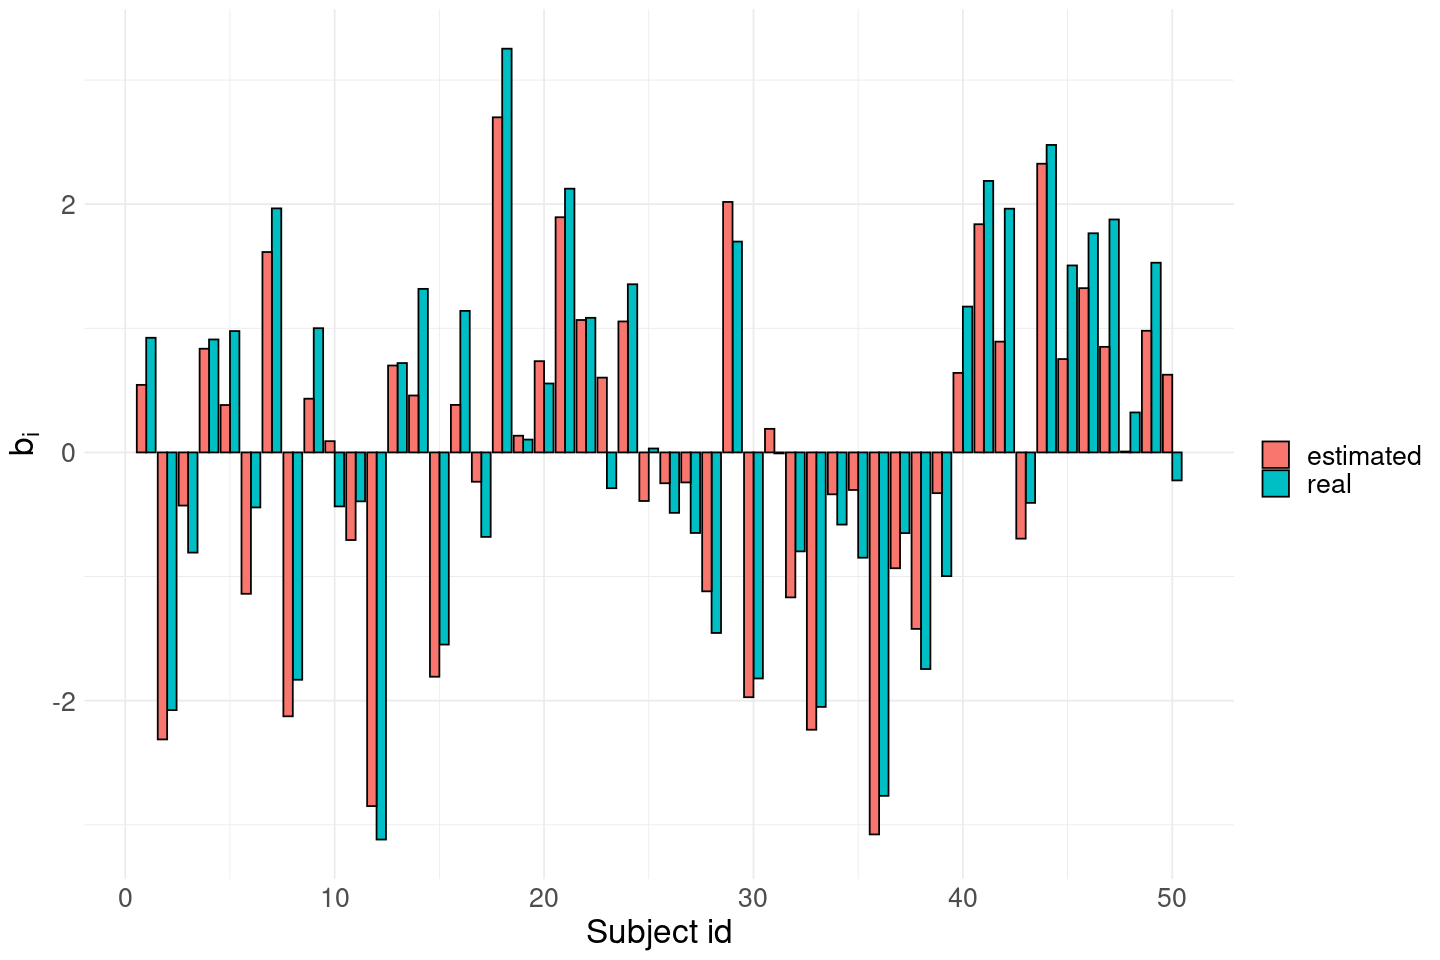

In [11]:
bi_compare <- data.frame(
    id = c( 1:N, 1:N ),
    bi = c( generate_data$bi %>% as.vector, as.vector(Reduce(rbind, fit_MERT$bi)) ),
    type = c( rep("real", N), rep("estimated", N) )
)

options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(bi_compare)+
    geom_col(aes(x = id, y = bi, fill = type), position = "dodge", color = "black")+
    labs(x = "Subject id", y = TeX("$b_i$"), fill = "")

In [12]:
cat(paste("real sigma2:", sigma2, "\n"))
cat(paste("estimated sigma2:", fit_MERT$sigma2,"\n\n"))

cat(paste("real D:", D, "\n"))
cat(paste("estimated D:", fit_MERT$D))

real sigma2: 1 
estimated sigma2: 1.02866384840009 

real D: 2 
estimated D: 1.86834608359079

As we can see, all the random effects seem to have been predicted with some satisfatory precision. Also we can see that for the variance structures everything seems to be estimated correctly.

## Random intercepts and slopes

In [13]:
N <- nrow(df_grouped)

Ys <- df_grouped$Y

# Recover all the matrices Xi from every subject (intercept + time in this case)
Xis <- apply(df_grouped, 1, function(row){
    dfi <- as.data.frame(row) %>% unnest(cols = c("Y", "t"))
    Xi <- model.matrix(Y ~ t, data = dfi)
    list(Xi)
}) %>% unlist(recursive = FALSE)

# Recover all the matrices Zi from every subject according to the desired model (random intercept in this case)
Zis <- apply(df_grouped, 1, function(row){
    dfi <- as.data.frame(row) %>% unnest(cols = c("Y", "t"))
    Zi <- model.matrix(Y ~ 1 + t, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)

In [14]:
# Fixed intercept + slope
Xi <- matrix(c(
    1, 0, 1, 1, 1, 2, 1, 3, 1, 4, 1, 5
), ncol = 2, byrow = TRUE)
colnames(Xi) <- c("Intercept", "t")
beta <- c(1, 2)

# Random intercept model
Zi <- Xi[,c(1,2)]

D <- matrix(c(3,0.5,0.5,2), nrow = 2)
sigma2 <- 2

N <- 50
generate_data <- generate_sample(N, Xi, beta, Zi, D, sigma2)
df <- generate_data$data

# Group the dataset by subject index
df_grouped <- df %>% group_by(id) %>% summarise(
    Y = list(Y),
    t = list(t)
)
head(df_grouped, 4)

id,Y,t
<int>,<list>,<list>
1,"2.528677, 5.285319, 5.144782, 6.367197, 10.730046, 9.693152","0, 1, 2, 3, 4, 5"
2,"-2.1953876, -0.8833286, 0.1153331, 2.5891511, 4.8532603, 6.3469275","0, 1, 2, 3, 4, 5"
3,"4.160461, 5.030821, 12.599550, 20.998475, 19.979232, 27.603041","0, 1, 2, 3, 4, 5"
4,"2.668797, 3.543079, 7.225691, 8.345633, 9.294486, 14.804782","0, 1, 2, 3, 4, 5"


In [15]:
N <- nrow(df_grouped)

Ys <- df_grouped$Y

# Recover all the matrices Xi from every subject (intercept + time in this case)
Xis <- apply(df_grouped, 1, function(row){
    dfi <- as.data.frame(row) %>% unnest(cols = c("Y", "t"))
    Xi <- model.matrix(Y ~ t, data = dfi)
    list(Xi)
}) %>% unlist(recursive = FALSE)

# Recover all the matrices Zi from every subject according to the desired model (random intercept in this case)
Zis <- apply(df_grouped, 1, function(row){
    dfi <- as.data.frame(row) %>% unnest(cols = c("Y", "t"))
    Zi <- model.matrix(Y ~ 1 + t, data = dfi)
    list(Zi)
}) %>% unlist(recursive = FALSE)

In [16]:
start <- Sys.time()
    fit_MERT <- train_MERT(df, Y ~ t, Ys, Xis, Zis, 1.0e-6, max_iter = 10000)
Sys.time() - start

Converged after 231 iterations.

Time difference of 2.347782 secs

In [17]:
cat(paste("real sigma2:", sigma2, "\n"))
cat(paste("estimated sigma2:", fit_MERT$sigma2,"\n\n"))

cat(paste("real D:\n"))
D
cat(paste("estimated D:\n"))
fit_MERT$D

real sigma2: 2 
estimated sigma2: 2.31783809827298 

real D:


3.0,0.5
0.5,2.0


estimated D:


3.2678954,0.8638527
0.8638527,2.3603296


In [18]:
# Predict the response for an individual, given its matrices Xi and Zi.
# The individuals ids have to be specified in order to use the random effects. If not its assumed bi unobserved (just the population mean)
predict_MERT <- function(fit, Xis, Zis, ids = NULL){
    
    predict_single <- function(fit, Xi, Zi, id){
        Xi <- as.data.frame(Xi)
        Zi <- as.data.frame(Zi)
        
        fixed_part <- predict(fit$f, newdata = Xi)
        
        # If the subject id is not given, assume its a new individual, returning just the population mean
        if(is.null(id)){
            return( fixed_part )
        }
        
        random_part <- as.matrix(Zi) %*% as.matrix(fit$bi[[id]]) %>% as.vector
        return( fixed_part + random_part )
    }
    
    # Check if it's a single prediction or a list of predictions to be made
    if( any(class(Xis) != "list") ){
        return( predict_single(fit, Xis, Zis, ids) )
    }else{
        pred <- c()
        for(i in 1:length(Xis)){
            id <- ids[i]
            Xi <- Xis[[i]]
            Zi <- Zis[[i]]
            pred[i] <- predict_single(fit, Xi, Zi, id)
        }
        return(pred)
    }
}

In [19]:
ts <- seq(0, 6, 0.1)
Xi_pred <- matrix(c(
    rep(1, length(ts)),
    ts
), ncol = 2) %>% as.data.frame
colnames(Xi_pred) <- c("(Intercept)", "t")
Zi_pred <- Xi_pred

y_pred <- predict_MERT(fit_MERT, Xi_pred, Zi_pred)
y_pred_id2 <- predict_MERT(fit_MERT, Xi_pred, Zi_pred, ids = 2)

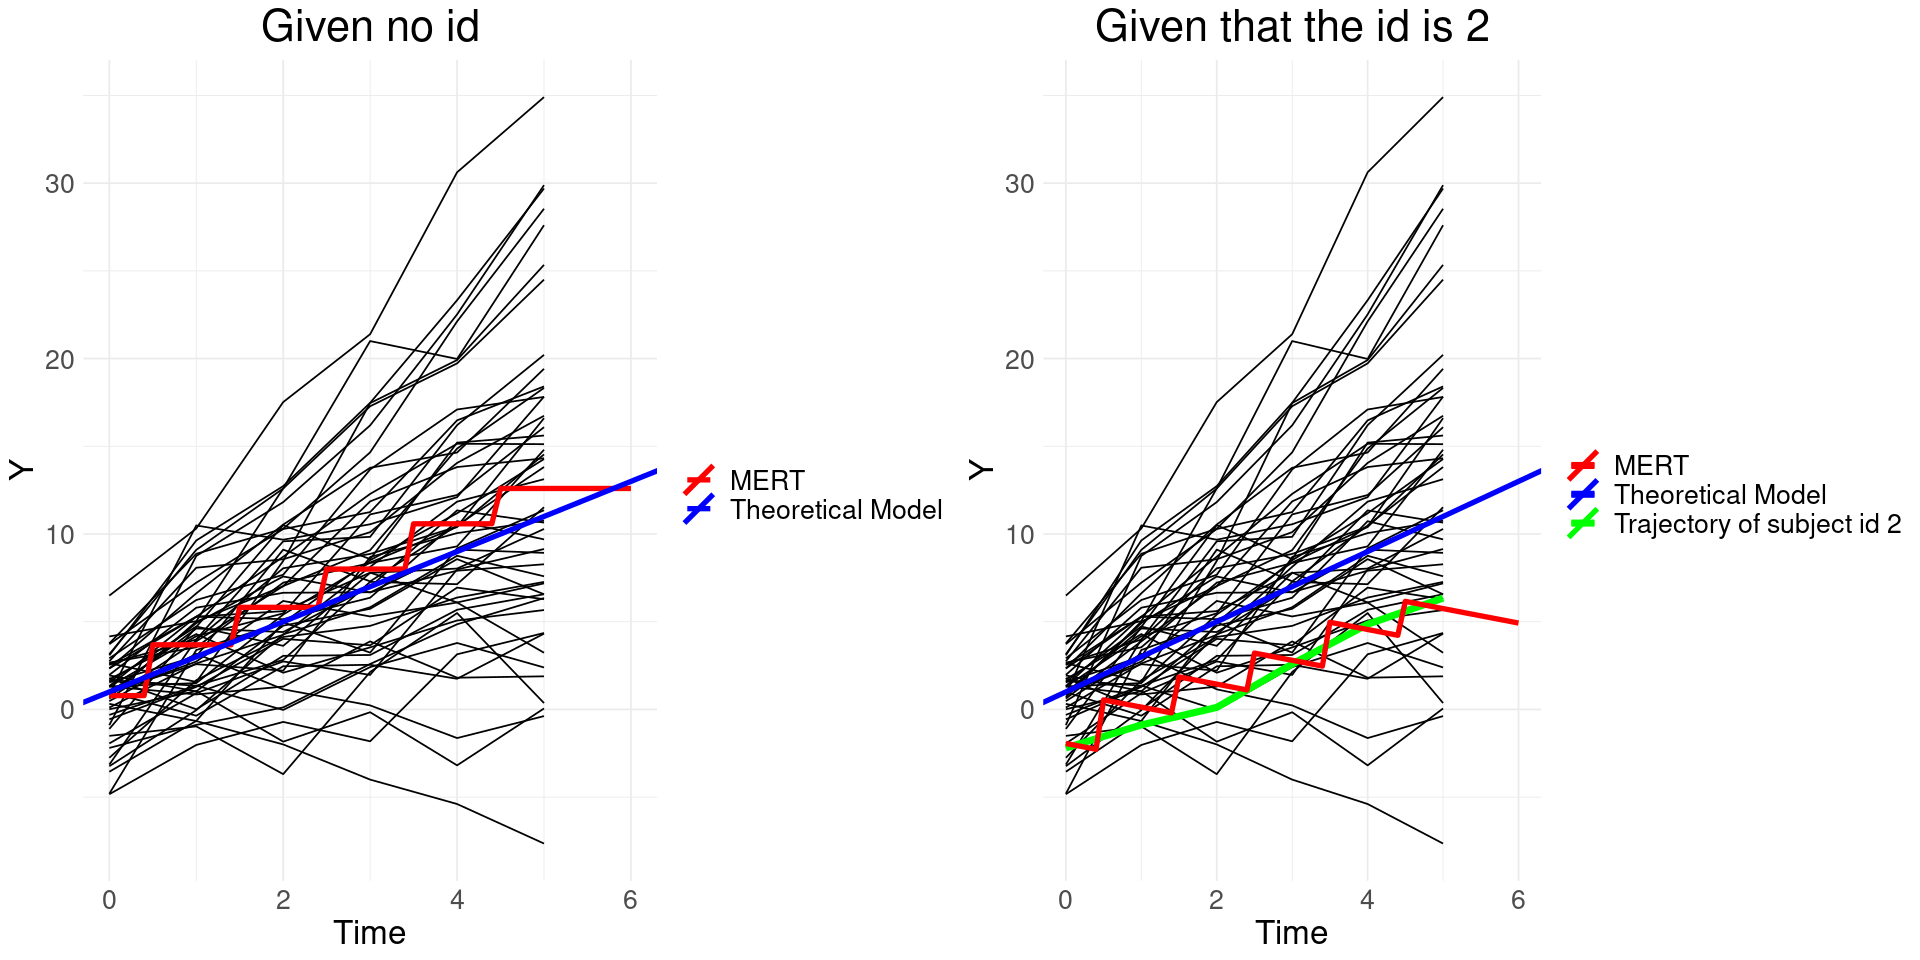

In [20]:
# Considering that the individual was not seen on the dataset
g1 <- ggplot()+
    geom_line(df, mapping = aes(x = t, y = Y, group = id))+
    geom_line(aes(x = ts, y = y_pred, color = "MERT"), linewidth = 1.5)+
    geom_abline(mapping = aes(intercept = beta[1], slope = beta[2], color = "Theoretical Model"), linewidth = 1.5)+
    scale_color_manual(values = c("red", "blue"))+
    labs(title = "Given no id", x = "Time", y = "Y", color = "")

# Considering that the individual id is given by 1
g2 <- ggplot()+
    geom_line(df, mapping = aes(x = t, y = Y, group = id))+
    geom_line(df %>% filter(id == 2), mapping = aes(x = t, y = Y, color = "Trajectory of subject id 2"), linewidth = 2)+
    geom_line(aes(x = ts, y = y_pred_id2, color = "MERT"), linewidth = 1.5)+
    geom_abline(mapping = aes(intercept = beta[1], slope = beta[2], color = "Theoretical Model"), linewidth = 1.5)+
    scale_color_manual(values = c("red", "blue", "green"))+
    labs(title = "Given that the id is 2", x = "Time", y = "Y", color = "")

options(repr.plot.width = 16, repr.plot.height = 8)
plot_grid(g1, g2, nrow = 1)

As it can be seen, once we give the model the information on which subject from the training dataset we are refering to, the model is able to improve its prediction, centering around the trajectory of this individual.